# Check that IC runs as expected

In [1]:
import os
import sys
import numpy  as np
import tables as tb
from glob       import glob
from matplotlib import pyplot as plt
from invisible_cities.cities.irene           import Irene
from invisible_cities.cities.dorothea        import Dorothea
from invisible_cities.cities.penthesilea     import Penthesilea
from invisible_cities.cities.irene_test      import unpack_s12params, s12params
from invisible_cities.types.ic_types_c       import minmax
from invisible_cities.core.system_of_units_c import units
from invisible_cities.core.configure         import configure
from invisible_cities.reco import peak_functions_c as cpf
from invisible_cities.reco import peak_functions   as  pf
from invisible_cities.io   import pmap_io          as pio
from invisible_cities.io   import dst_io           as dio
from invisible_cities.evm.pmaps import S1, S2, S2Si, Peak
sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
import icaro.marco_polo.monitor_functions as mf

# irene

In [2]:
ic_data = os.path.join(os.environ['IC_DATA'])
run = 0
conf_path = '/Users/alej/Desktop/Valencia/nextic/IC-1/invisible_cities/config/irene.conf'
PATH_IN  =  ic_data + 'Montecarlo/Kr/new_mc/dst_NEXT_v1_00_05_Kr_ACTIVE_0_0_7bar_RWF_1000.root.h5'
PATH_OUT  = ic_data + 'Montecarlo/Kr/new_mc/dst_NEXT_v1_00_05_Kr_ACTIVE_0_0_7bar_pmaps_1000.root.h5.h5'
pmap_path = PATH_OUT
rwf_path = PATH_IN

# initialize irene
conf     = configure(('dummy ' + conf_path).split()).as_dict
conf.update(dict(run_number = run,
             files_in   = PATH_IN,
             file_out   = PATH_OUT,
             nmax       = 1000,
             **unpack_s12params(s12params())))

irene = Irene(**conf)
irene.thr_sipm    =  2*units.pes
irene.thr_sipm_s2 = 15*units.pes
#irene.run() # Turn on to generate new pmap_path

1


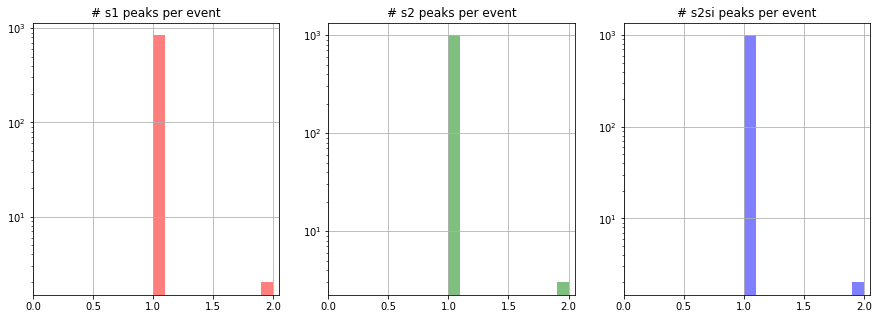

In [3]:
with tb.open_file(rwf_path, 'r+') as f_rwfs:
    events = [f_rwfs.root.Run.events[i][0] for i in range(len(f_rwfs.root.Run.events[:]))]
nevts = len(events)
s1_dict, s2_dict, s2si_dict = pio.load_pmaps(pmap_path)
ns1s   = [len(s1.s1d)     for s1   in   s1_dict.values()]
ns2s   = [len(s2.s2d)     for s2   in   s2_dict.values()]
ns2sis = [len(s2si.s2sid) for s2si in s2si_dict.values()]

plt.figure(figsize=(15,5))
subplot=131
labs  = ['s1 peaks', 's2 peaks', 's2si peaks']
color = ['red', 'green', 'blue']
for i, nsis in enumerate([ns1s, ns2s, ns2sis]):
    plt.subplot(subplot)
    plt.hist(nsis, color=color[i], alpha=.5)
    plt.title('# ' + labs[i] + ' per event')
    plt.yscale('log')
    plt.xlim(0, None)
    plt.grid(True)
    subplot+=1
plt.show()
ev_sample = mf.sample_events(9, rwf_path)
i_ev = ev_sample - events[0]
CSUMs, csipm = mf.calibrated_waveforms(i_ev, irene, rwf_path, sipms=True)

#### Some S1s
These should be exact copies of the waveform since there is no rebinning

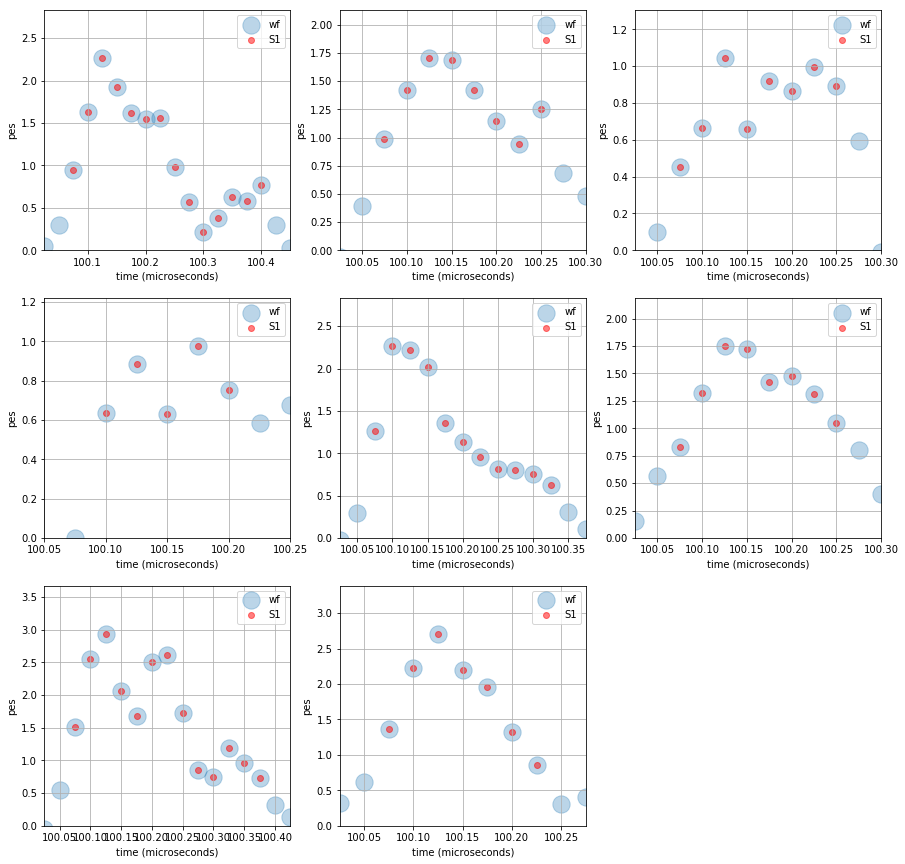

In [4]:
plt.figure(figsize=(15,15))
subplot=331
for i, ev in zip(i_ev, ev_sample):
    if ev in s1_dict:
        pn = np.array(list(s1_dict[ev].peaks.keys())).max() # choose 1 peak_no (here max)
        mf.plot_wf_vs_s12_peak(CSUMs[i], s1_dict[ev].peaks[pn], subplot=subplot)
        subplot+=1
plt.show()

#### Some S2s 
There has been rebinning, so S2 should look like a best fit line to the wf.    
Note: s2 amplitudes have been multipled by (wf time bin size 25ns / s2 time bin size 1000ns) so that amplitudes match    

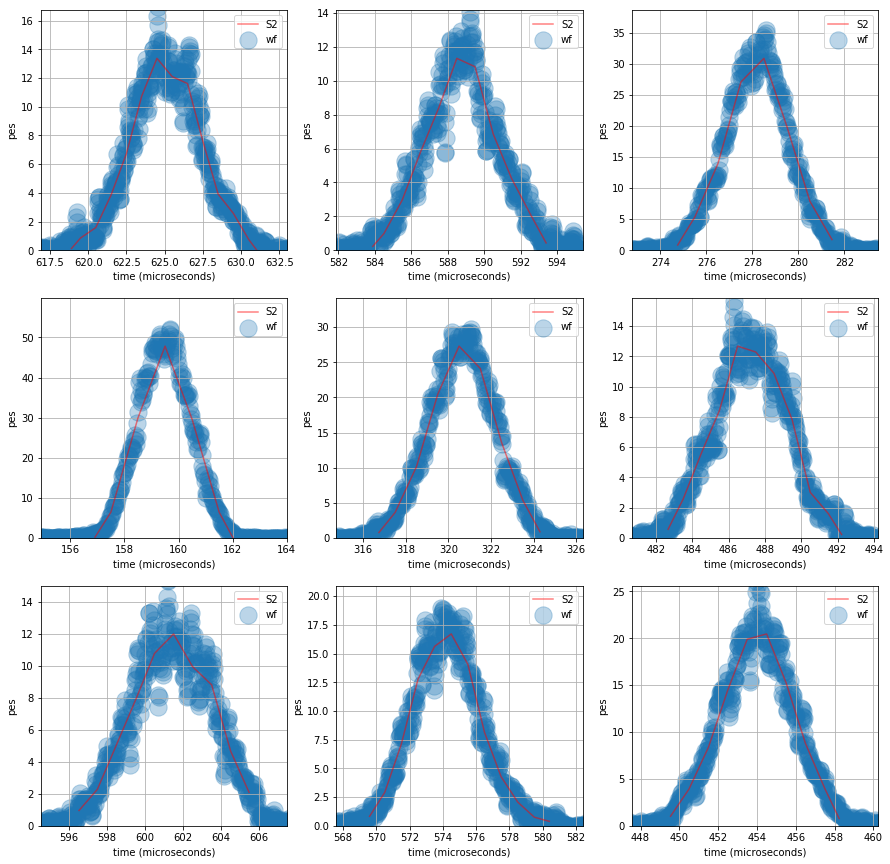

In [5]:
plt.figure(figsize=(15,15))
subplot=331
for i, ev in zip(i_ev, ev_sample):
    if ev in s2_dict:
        pn = np.array(list(s2_dict[ev].peaks.keys())).max()
        mf.plot_wf_vs_s12_peak(CSUMs[i], s2_dict[ev].peaks[pn], 
                            subplot=subplot, 
                            pkbs=units.mus, 
                            plotp=plt.plot,
                            S12='S2',
                            pc='r')    
    subplot+=1
plt.show()

#### Some S2Si
The S2Si should look very similar to the wf. If S2Si threshold is set to zero, data points in the wf and S2Si should match perfectly. Since typically the threshold is quite high ~3.5pes, we cannot expect an exact match between the data points, typically the S2Si peak should be slightly smaller than the peak seen in the wf.   

Note: light arriving to the first SiPM time bin arrives on average at .5mus not at 0mus and `rebin_waveform` takes this into account by construction


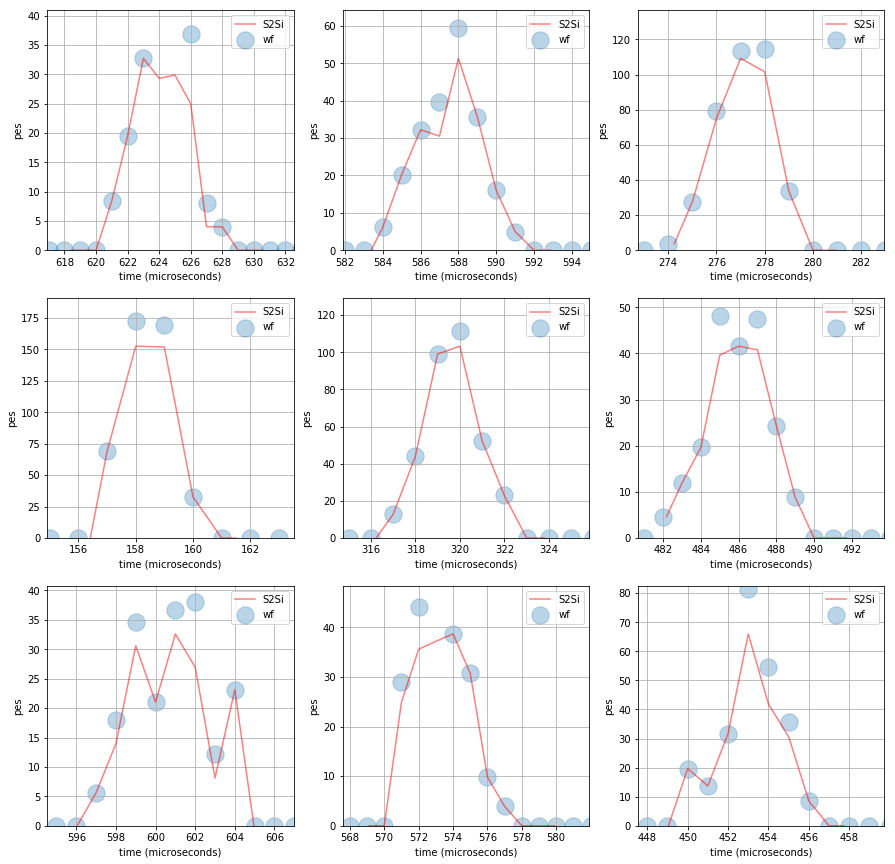

In [6]:
subplot=331
plt.figure(figsize=(15,15))
for i, ev in zip(i_ev, ev_sample):
    if not ev in s2si_dict: continue
    s2si = s2si_dict[ev]
    pn = np.array(list(s2si.peaks.keys())).max()
    t = s2si.s2d[pn][0]
    s2si_sum = np.zeros_like(t)
    for sipm in s2si.s2sid[pn]: 
        s2si_sum += s2si.s2sid[pn][sipm]
    mf.plot_wf_vs_s12_peak(np.array(csipm[i]), Peak(t, s2si_sum),
                        subplot=subplot,
                        wfbs=units.mus,
                        pkbs=units.mus,
                        plotp=plt.plot,
                        S12='S2Si',
                        pc='r')
    subplot+=1
plt.show()

# dorothea

In [7]:
# initialize dorothea
conf_path = '/Users/alej/Desktop/Valencia/nextic/IC-1/invisible_cities/config/dorothea.conf'
PATH_IN  = os.path.join(pmap_path)
DORO_OUT = os.path.join('/Users/alej/Desktop/dorothea/garbage.h5')
conf     = configure(('dummy ' + conf_path).split()).as_dict
conf.update(dict(run_number = run,
                 files_in   = PATH_IN,
                 file_out   = DORO_OUT,
                 nmax       = 100000))
dorothea = Dorothea(**conf)
#dorothea.run()

In [8]:
doro = dio.load_dst(DORO_OUT, "DST", "Events")
events_in_doro = doro.event.values
n_events_represented_in_doro = len(set(events_in_doro))
print('Efficiency: ' + str(n_events_represented_in_doro / 1000))

Efficiency: 0.822


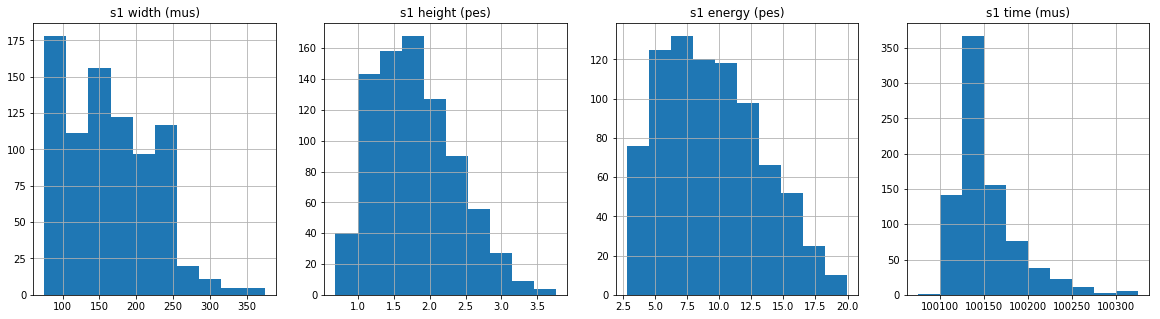

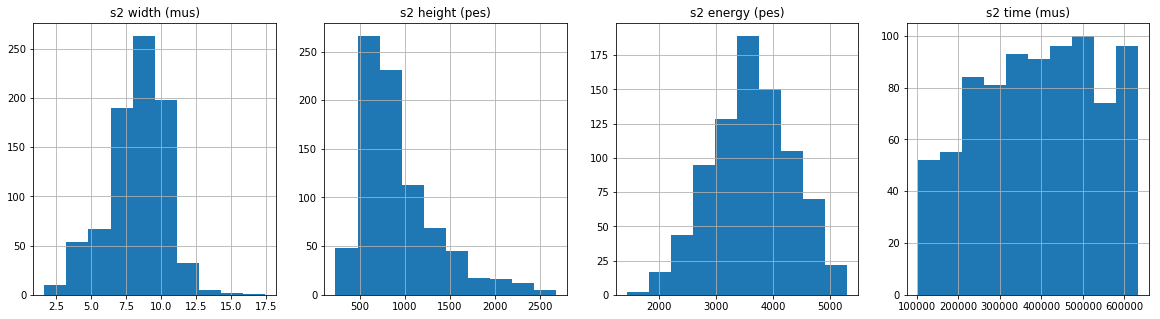

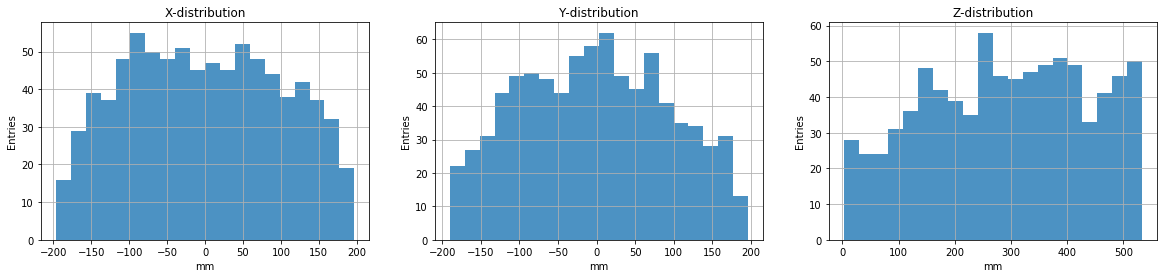

In [9]:
plt.figure(figsize=(20,5))
subplot=141
for feature, lab in zip([doro.S1w, doro.S1h, doro.S1e, doro.S1t], 
                   ['s1 width (mus)', 's1 height (pes)', 's1 energy (pes)', 's1 time (mus)']):
    plt.subplot(subplot)
    if lab=='s1 time':plt.hist(feature / units.mus)
    else:plt.hist(feature)
    plt.title(lab)
    plt.grid(True)
    subplot+=1
plt.show()  
plt.figure(figsize=(20,5))
subplot=141
for feature, lab in zip([doro.S2w, doro.S2h, doro.S2e, doro.S2t], 
                   ['s2 width (mus)', 's2 height (pes)', 's2 energy (pes)', 's2 time (mus)']):
    plt.subplot(subplot)
    if lab=='s2 time':plt.hist(feature / units.mus)
    else:plt.hist(feature)
    plt.title(lab)
    plt.grid(True)
    subplot+=1
plt.show()  
plt.figure(figsize=(20,4))
subplot=131
for feature, coord in zip([doro.X, doro.Y, doro.Z], ['X', 'Y', 'Z']):
    plt.subplot(subplot)
    plt.hist(feature, bins=20, alpha=.8)
    plt.title(coord + '-distribution')
    plt.xlabel('mm')
    plt.ylabel('Entries')
    plt.grid(True)
    subplot+=1
plt.show()

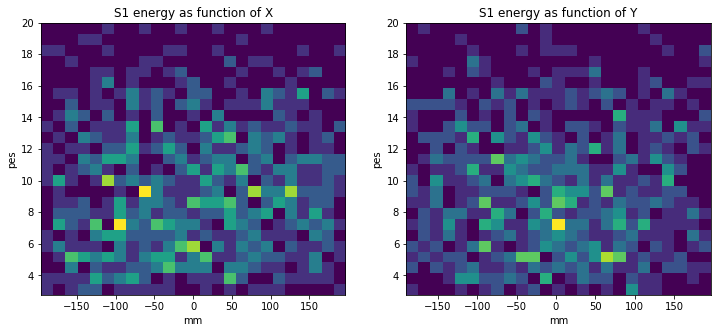

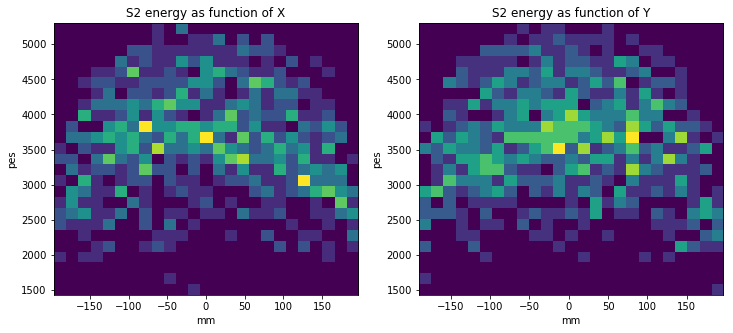

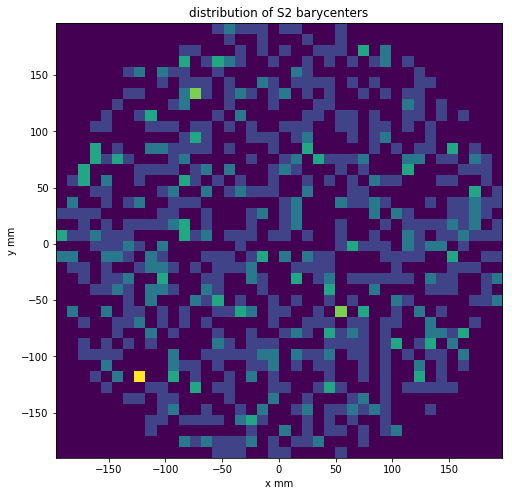

In [10]:
plt.figure(figsize=(12,5))
subplot=121
for feature, lab in zip([doro.X, doro.Y], ['X', 'Y']):
    plt.subplot(subplot)
    plt.hist2d(feature, doro.S1e, bins=25)
    plt.title('S1 energy as function of ' + lab)
    plt.xlabel('mm')
    plt.ylabel('pes')
    subplot+=1
plt.show()
plt.figure(figsize=(12,5))
subplot=121
for feature, lab in zip([doro.X, doro.Y], ['X', 'Y']):
    plt.subplot(subplot)
    plt.hist2d(feature, doro.S2e, bins=25)
    plt.title('S2 energy as function of ' + lab)
    plt.xlabel('mm')
    plt.ylabel('pes')
    subplot+=1
plt.show()
plt.figure(figsize=(8,8))
plt.hist2d(doro.X, doro.Y, bins=(40, 40))
plt.xlabel('x mm') 
plt.ylabel('y mm')
plt.title('distribution of S2 barycenters')
plt.show()

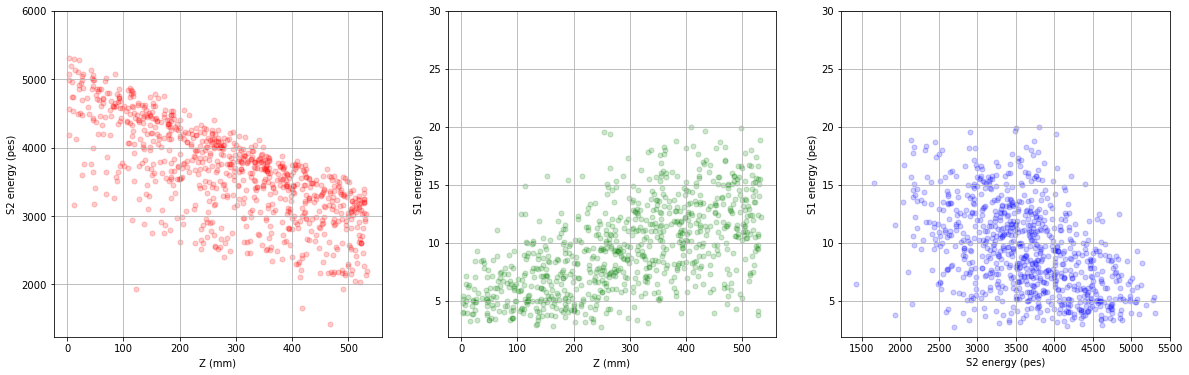

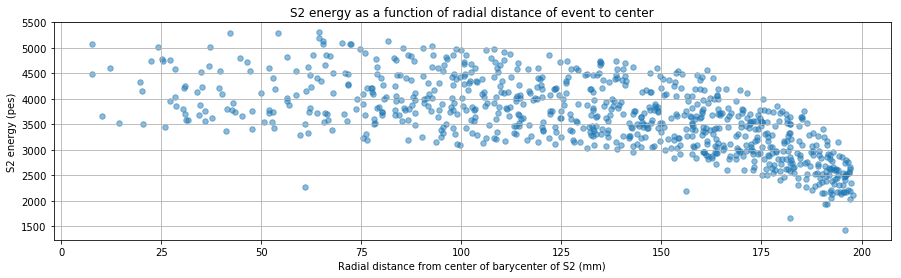

In [11]:
figsize=(20,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.scatter(doro.Z, doro.S2e, c='r', s=25, alpha=.2)
plt.xlabel('Z (mm)')
plt.ylabel('S2 energy (pes)')
plt.ylim(None,6000)
plt.grid(True)
ax = plt.subplot(1, 3, 2)
plt.scatter(doro.Z, doro.S1e, c='g', s=25, alpha=.2)
plt.xlabel('Z (mm)')
plt.ylabel('S1 energy (pes)')
plt.ylim(None,30)
plt.grid(True)
ax = plt.subplot(1, 3, 3)
plt.scatter(doro.S2e, doro.S1e, c='b', s=25, alpha=.2)
plt.xlabel('S2 energy (pes)')
plt.ylabel('S1 energy (pes)')
plt.ylim(None,30)
plt.grid(True)
plt.show()
plt.figure(figsize=(15,4))
plt.scatter(doro.R, doro.S2e, s=30, alpha=.5)
plt.grid(True)
plt.title('S2 energy as a function of radial distance of event to center')
plt.xlabel('Radial distance from center of barycenter of S2 (mm)')
plt.ylabel('S2 energy (pes)')
plt.show()


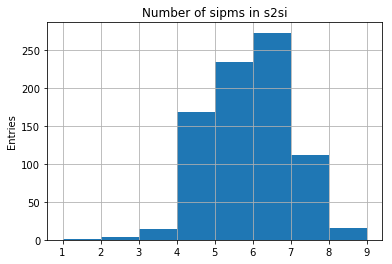

In [12]:
plt.figure(figsize=(6,4))
plt.hist(doro.Nsipm, bins=range(1, doro.Nsipm.max()+1))
plt.grid(True)
plt.ylabel('Entries')
plt.title('Number of sipms in s2si')
plt.show()

# penthesilea

In [13]:
# initialize penthesilea
conf_path = '/Users/alej/Desktop/Valencia/nextic/IC-1/invisible_cities/config/penthesilea.conf'
PATH_IN  = os.path.join(pmap_path)
PENT_OUT = os.path.join('/Users/alej/Desktop/penthesilea/garbage.h5')
conf     = configure(('dummy ' + conf_path).split()).as_dict
conf.update(dict(run_number = run,
                 files_in   = PATH_IN,
                 file_out   = PENT_OUT,
                 rebin      = 30,
                 nmax       = 100000))
penthesilea = Penthesilea(**conf)
#penthesilea.run()

In [14]:
pent = dio.load_dst(PENT_OUT, 'RECO', 'Events')
events_in_pent = pent.event.values
n_events_represented_in_pent = len(set(events_in_pent))
print('Efficiency: ' + str(n_events_represented_in_pent / 1000))

Efficiency: 0.822


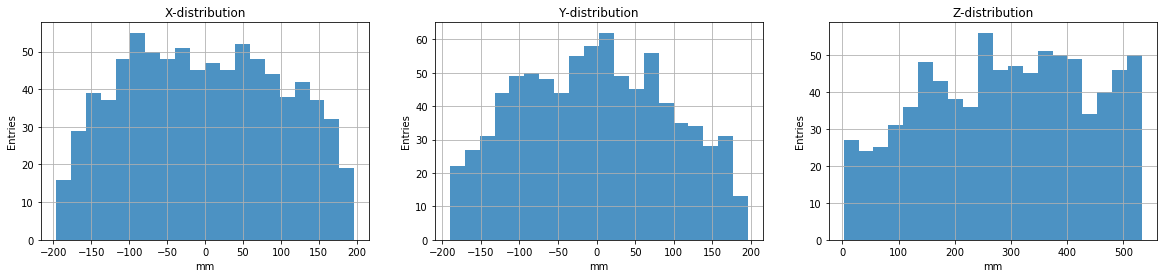

In [15]:
plt.figure(figsize=(20,4))
subplot=131
for feature, coord in zip([pent.X, pent.Y, pent.Z], ['X', 'Y', 'Z']):
    plt.subplot(subplot)
    plt.hist(feature, bins=20, alpha=.8)
    plt.title(coord + '-distribution')
    plt.xlabel('mm')
    plt.ylabel('Entries')
    plt.grid(True)
    subplot+=1
plt.show()

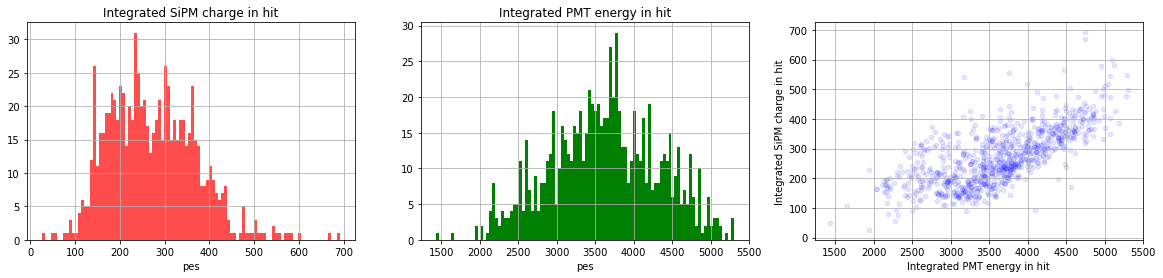

In [16]:
plt.figure(figsize=(20, 4))
plt.subplot(131); plt.hist(pent.Q, bins=100, color='r', alpha=.7)
plt.title('Integrated SiPM charge in hit')
plt.xlabel('pes')
plt.grid(True)
plt.subplot(132); plt.hist(pent.E, bins=100, color='g')
plt.title('Integrated PMT energy in hit')
plt.xlabel('pes')
plt.grid(True)
plt.subplot(133); plt.scatter(pent.E, pent.Q, s=20, c='b', alpha=.1)
plt.xlabel('Integrated PMT energy in hit')
plt.ylabel('Integrated SiPM charge in hit')
plt.grid(True)
plt.show()

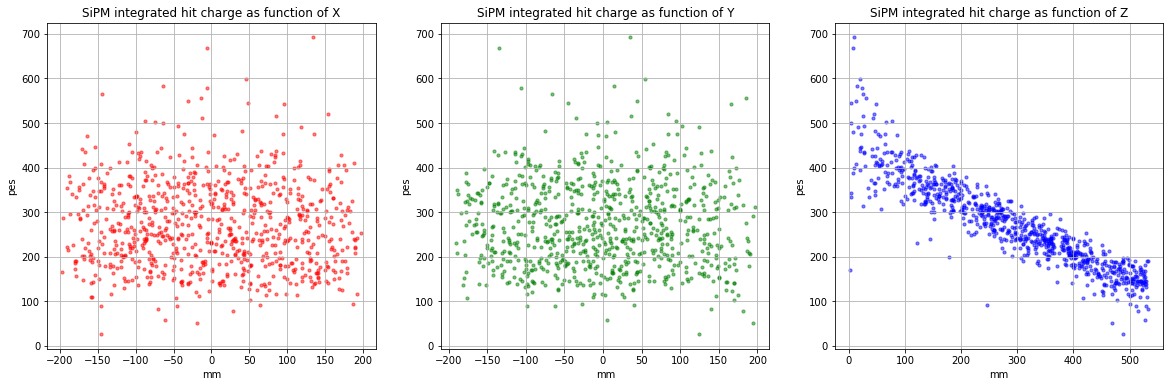

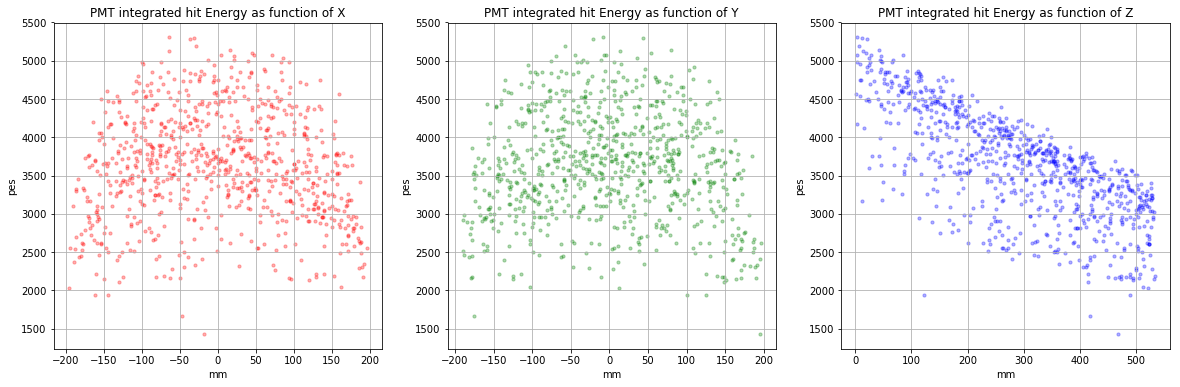

In [17]:
plt.figure(figsize=(20,6))
subplot=131
C = ['r', 'g', 'b']
for feature, lab, c  in zip([pent.X, pent.Y, pent.Z], ['X', 'Y', 'Z'], C):
    plt.subplot(subplot)
    plt.scatter(feature, pent.Q, s=10, c=c, alpha=.5)
    plt.title('SiPM integrated hit charge as function of ' + lab)
    plt.xlabel('mm')
    plt.ylabel('pes')
    subplot+=1
    plt.grid(True)
plt.show()
plt.figure(figsize=(20,6))
subplot=131
for feature, lab, c  in zip([pent.X, pent.Y, pent.Z], ['X', 'Y', 'Z'], C):
    plt.subplot(subplot)
    plt.scatter(feature, pent.E, s=10, c=c, alpha=.3)
    plt.title('PMT integrated hit Energy as function of ' + lab)
    plt.xlabel('mm')
    plt.ylabel('pes')
    subplot+=1
    plt.grid(True)
plt.show()

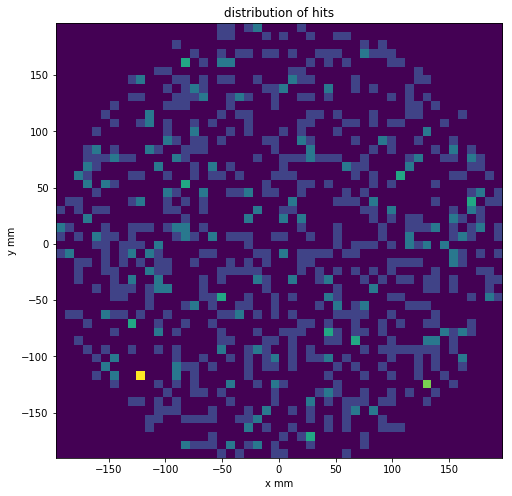

In [18]:
plt.figure(figsize=(8,8))
plt.hist2d(pent.X, pent.Y, bins=(50, 50))
plt.xlabel('x mm') 
plt.ylabel('y mm')
plt.title('distribution of hits')
plt.show()

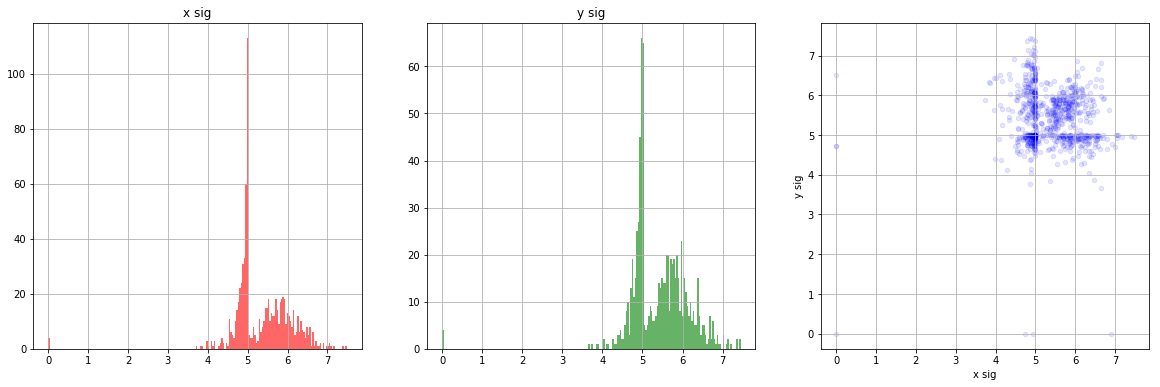

In [19]:
plt.figure(figsize=(20,6))
from matplotlib.colors import LogNorm
subplot=131
labels = ['x sig', 'y sig']
C = ['red', 'green']
for feature, lab , c in zip([pent.Xrms, pent.Yrms], labels, C):
    plt.subplot(subplot)
    plt.hist(feature, bins=200, color=c, alpha=.6)
    plt.title(lab)
    plt.grid(True)
    subplot+=1
plt.subplot(subplot)
plt.scatter(pent.Xrms, pent.Yrms, s=20, alpha=.1, c='b')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.grid(True)
plt.show()

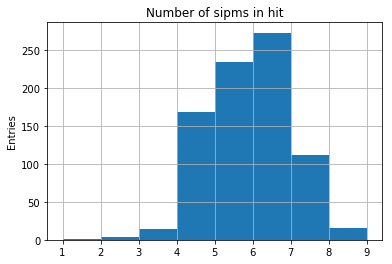

In [20]:
plt.figure(figsize=(6,4))
plt.hist(pent.nsipm, bins=range(1, pent.nsipm.max()+1))
plt.grid(True)
plt.ylabel('Entries')
plt.title('Number of sipms in hit')
plt.show()